<a href="https://colab.research.google.com/github/jg100/torch-ddpm-sampler/blob/main/ddpm_model_FLOATFIXED.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%pip install torch torchvision tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 123.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 93.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 52.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 39.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 19.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 105.2 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvji

In [2]:
import torch
import torch.nn as nn
import torchvision

In [3]:

device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps" #Device for apple silicon (Metal Performance Shaders)
    if torch.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")


class UNet(nn.Module):
    def __init__(self, img_channels=3, base_channels=64):
      super().__init__()
      self.conv1 = nn.Conv2d(img_channels, base_channels, 3, 1, 1)
      self.conv2 = nn.Conv2d(base_channels, base_channels, 3, 1, 1)
      self.conv3 = nn.Conv2d(base_channels, img_channels, 3, 1, 1)

    def forward(self, x, t):
      # x is noisy image tensor and t is is timestamp
      h = torch.relu(self.conv1(x))
      h = torch.relu(self.conv2(h))
      h = torch.relu(self.conv3(h))
      return h #predict noise component


Using cuda device


In [14]:
class DDPM:
  def __init__(self, model, betas, device):
    self.model = model
    self.device = device
    self.betas = torch.tensor(betas).to(device)
    self.alphas = 1. - self.betas
    self.alpha_bars = torch.cumprod(self.alphas, dim=0)

  def q_sample(self, x_start, t, noise=None): #computes cumulative products for noise schedules
    if (noise is None):
      noise = torch.randn_like(x_start, dtype=torch.float32)

    sqrt_a_bar = self.alpha_bars[t].sqrt().view(-1,1,1,1)
    sqrt_one_minus_a_bar = (1. - self.alpha_bars[t]).sqrt().view(-1,1,1,1)

    return sqrt_a_bar * x_start + sqrt_one_minus_a_bar * noise

  def p_sample(self, x, t, t_index): #applies forward diffusion at time t
    noise_pred = self.model(x.float(), t)
    beta_t = self.betas[t].view(-1,1,1,1)
    alpha_t = self.alphas[t].view(-1,1,1,1)
    alpha_t_bar = self.alpha_bars[t].view(-1,1,1,1)
    coef1 = 1 / alpha_t.sqrt()
    coef2 = (1 - alpha_t) / (1 - alpha_t_bar).sqrt()
    pred_x0 = (x - coef2 * noise_pred) / coef1
    noise = torch.randn_like(x, dtype=torch.float32) if t[0] > 0 else torch.tensor(0.0, dtype=torch.float32, device=x.device)
    return coef1 * (pred_x0 + coef2 * noise_pred) + beta_t.sqrt() * noise

  def sample(self, shape, steps=1000):
    x = torch.randn(shape, dtype=torch.float32).to(self.device)
    for i in reversed(range(steps)):
      t = torch.full((shape[0],), i, device = self.device, dtype=torch.long)
      x = self.p_sample(x, t, i)
    return x

## Training

In [15]:
import torch
from torch.optim import Adam
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
import numpy as np

In [16]:
transform = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.ToTensor(),
    transforms.Normalize([0.5] * 3, [0.5] * 3)
])

In [38]:
from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms

debug = True #Set this to true to debug syntax or logic errors in model

if debug == False:
  dataset = datasets.Places365(
        root="data/places",
        split="train-standard",
        small=True,
        download=True,
        transform=transform
    )
else:
  class TwoImageDataset(Dataset):
      def __init__(self, image_paths, transform=None):
          # Check if exactly two image paths are provided
          if len(image_paths) != 2:
              raise ValueError("Exactly two image paths must be provided.")

          # Load the images and ensure they are in RGB format
          self.image1 = Image.open(image_paths[0]).convert("RGB")
          self.image2 = Image.open(image_paths[1]).convert("RGB")
          self.transform = transform

      def __len__(self):
          return 1  # This dataset still represents a single "pair" or "batch" conceptually

      def __getitem__(self, idx):
          # This dataset only has one item (the pair of images)
          if idx != 0:
              raise IndexError("Index out of range")

          img1 = self.image1
          img2 = self.image2

          # Apply transform to both images
          if self.transform:
              img1 = self.transform(img1)
              img2 = self.transform(img2)

          # Return a tuple of the two image tensors
          return (img1, img2)

  transform = transforms.Compose([
      transforms.Resize((256, 256)),
      transforms.ToTensor(),
      transforms.Normalize([0.5] * 3, [0.5] * 3)
  ])
  try:
      dataset = TwoImageDataset(["spotify.png", "album.png"], transform=transform)
      loader = DataLoader(dataset, batch_size=1, shuffle=False)

  except FileNotFoundError as e:
      print(f"Error loading image: {e}. Please make sure 'spotify.png' and 'another_image.png' exist.")
  except ValueError as e:
      print(f"Error creating dataset: {e}")

In [18]:
loader = DataLoader(dataset, batch_size=64, shuffle= True, num_workers=2)

In [19]:
model = UNet().to(device)
optimizer = Adam(model.parameters(), lr=1e-4)
betas = np.linspace(1e-4, 0.02, 1000)
ddpm = DDPM(model, betas, device)

In [ ]:
# initializing model, optimizer, and diffusion scheduler

In [20]:
for epoch in range(10):
  print(f"\n--- Epoch {epoch+1} ---")

  for step, (imgs, _) in enumerate(loader):
    x = imgs.to(device).float()
    t = torch.randint(0, 1000, (x.size(0),), device=device).long()
    noise = torch.randn_like(x, dtype=torch.float32)

    # Debug shapes
    if step == 0:
        print(f"[Step {step}] x shape: {x.shape}")
        print(f"[Step {step}] Sample t: {t[:5].tolist()}")  # Show 5 sample timesteps
        print(f"[Step {step}] noise mean/std: {noise.mean().item():.4f}/{noise.std().item():.4f}")

    # Add noise
    x_noisy = ddpm.q_sample(x, t, noise).float()

    # Predict noise
    noise_pred = model(x_noisy, t)

    # Compute loss
    loss = torch.nn.functional.mse_loss(noise_pred, noise)

    # Backprop and update
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if step % 100 == 0:
      print(f"[Step {step}] Loss: {loss.item():.4f}")

  print(f"Epoch {epoch+1} final loss: {loss.item():.4f}")
  torch.save(model.state_dict(), f"checkpoint_epoch.pth")



--- Epoch 1 ---
[Step 0] x shape: torch.Size([1, 3, 256, 256])
[Step 0] Sample t: [383]
[Step 0] noise mean/std: -0.0007/1.0021
[Step 0] Loss: 1.0135
Epoch 1 final loss: 1.0135

--- Epoch 2 ---
[Step 0] x shape: torch.Size([1, 3, 256, 256])
[Step 0] Sample t: [812]
[Step 0] noise mean/std: 0.0015/0.9991
[Step 0] Loss: 1.0067
Epoch 2 final loss: 1.0067

--- Epoch 3 ---
[Step 0] x shape: torch.Size([1, 3, 256, 256])
[Step 0] Sample t: [349]
[Step 0] noise mean/std: -0.0055/0.9992
[Step 0] Loss: 0.9999
Epoch 3 final loss: 0.9999

--- Epoch 4 ---
[Step 0] x shape: torch.Size([1, 3, 256, 256])
[Step 0] Sample t: [554]
[Step 0] noise mean/std: -0.0015/0.9996
[Step 0] Loss: 0.9983
Epoch 4 final loss: 0.9983

--- Epoch 5 ---
[Step 0] x shape: torch.Size([1, 3, 256, 256])
[Step 0] Sample t: [725]
[Step 0] noise mean/std: 0.0035/0.9988
[Step 0] Loss: 0.9947
Epoch 5 final loss: 0.9947

--- Epoch 6 ---
[Step 0] x shape: torch.Size([1, 3, 256, 256])
[Step 0] Sample t: [931]
[Step 0] noise mean/std

## Image Generation

In [21]:
model.load_state_dict(torch.load("checkpoint_epoch", map_location=device))
model.eval()
ddpm_gen = DDPM(model, np.linspace(1e-4,0.02,1000), device)

<ipython-input-21-f52c8ff19f2e>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("checkpoint_epoch_9.pth", map_location=device))


In [23]:
with torch.no_grad():
    samples = ddpm.sample((16, 3, 256, 256), steps=1000).float()
    samples = (samples + 1) / 2
    print(samples)


tensor([[[[ 1.1783e-01, -2.5289e+00,  2.1680e+00,  ..., -1.4728e-01,
           -1.6258e+00,  8.7121e-01],
          [ 1.3820e+00,  2.0950e+00,  1.0782e+00,  ...,  7.8159e-01,
            1.4735e+00,  7.2782e-01],
          [ 1.3634e+00,  2.3962e+00,  1.7246e+00,  ...,  1.2038e+00,
            1.7429e+00, -1.1982e+00],
          ...,
          [-2.3075e-02,  9.1356e-01,  2.0397e+00,  ..., -7.1048e-02,
            1.3336e+00,  6.2173e-01],
          [ 2.4956e+00, -5.9192e-01, -2.2054e+00,  ..., -1.6355e+00,
            8.4742e-01,  3.7323e+00],
          [ 1.5388e+00, -4.8870e-01, -2.1873e-01,  ..., -1.0185e-01,
           -2.2159e-01,  2.1114e+00]],

         [[-1.7048e+00,  2.7390e+00,  7.0914e-01,  ..., -1.5413e-01,
            2.6981e-01,  3.8636e-01],
          [ 2.7748e+00, -6.0900e-01,  8.6096e-02,  ...,  1.5218e+00,
           -1.8505e+00, -2.1492e+00],
          [ 1.7928e+00,  3.4547e+00,  1.8275e+00,  ...,  7.1466e-01,
            3.0206e+00,  6.3433e-01],
          ...,
     

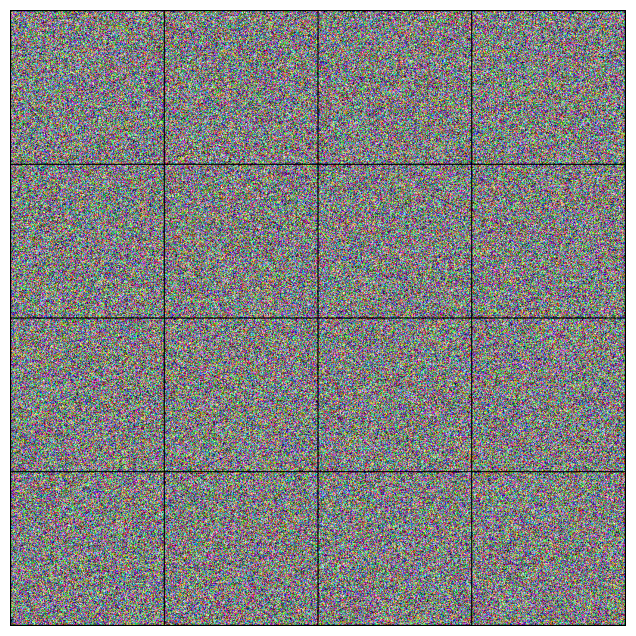

In [37]:
# Convert to CPU and clamp to [0, 1]
samples = samples.detach().cpu().clamp(0, 1)

# Make a grid (e.g., 4 rows of 4)
grid = make_grid(samples, nrow=4)

# Convert to HWC for matplotlib
img = TF.to_pil_image(grid)

# Display
plt.figure(figsize=(8, 8))
plt.imshow(img)
plt.axis("off")
plt.show()